In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import tensorflow as tf
assert tf.__version__ >= "2.0"

import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Plotting Activations & Its Derivative

In [2]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, g, eps = 0.0000001):
    return (f(z + eps) - f(z - eps))/(2*eps)

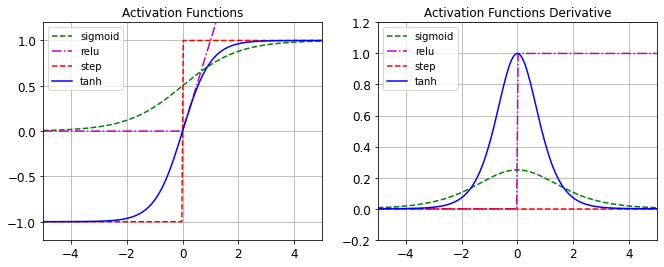

In [3]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize = (11, 4))

plt.subplot(121)
plt.plot(z, sigmoid(z),  'g--', label = 'sigmoid')
plt.plot(z, relu(z), 'm-.', label = 'relu')
plt.plot(z, np.sign(z), 'r--', label = 'step')
plt.plot(z, np.tanh(z), 'b-', label = 'tanh')
plt.grid(True)
plt.title("Activation Functions")
plt.legend()
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(sigmoid, z), 'g--', label = 'sigmoid')
plt.plot(z, derivative(relu, z), 'm-.', label = 'relu')
plt.plot(z, derivative(np.sign, z), 'r--', label = 'step')
plt.plot(z, derivative(np.tanh, z), 'b-', label = 'tanh')
plt.grid(True)
plt.title("Activation Functions Derivative")
plt.axis([-5, 5, -0.2, 1.2])
plt.legend()
plt.show()

## Regression MLP

In [4]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

housing = fetch_california_housing()

In [5]:
xtrain, xtest, ytrain, ytest = train_test_split(housing["data"], housing["target"], random_state = 42)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, random_state = 42)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xval = scaler.transform(xval)
xtest = scaler.transform(xtest)

### Sequential API

In [7]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation = 'relu',input_shape = xtrain.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(optimizer=keras.optimizers.SGD(lr=1e-3), loss = 'mse', metrics = ['mse'])
history = model.fit(xtrain, ytrain, epochs = 20, batch_size = 32, validation_data = (xval, yval))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 3s 281us/sample - loss: 1.9837 - mse: 1.9837 - val_loss: 0.8368 - val_mse: 0.8368
Epoch 2/20
11610/11610 [==============================] - 2s 158us/sample - loss: 0.7867 - mse: 0.7867 - val_loss: 0.6949 - val_mse: 0.6949
Epoch 3/20
11610/11610 [==============================] - 1s 91us/sample - loss: 0.7148 - mse: 0.7147 - val_loss: 0.6510 - val_mse: 0.6510
Epoch 4/20
11610/11610 [==============================] - 1s 101us/sample - loss: 0.6722 - mse: 0.6722 - val_loss: 0.6126 - val_mse: 0.6126
Epoch 5/20
11610/11610 [==============================] - 1s 99us/sample - loss: 0.6374 - mse: 0.6374 - val_loss: 0.5790 - val_mse: 0.5790
Epoch 6/20
11610/11610 [==============================] - 1s 95us/sample - loss: 0.6075 - mse: 0.6075 - val_loss: 0.5601 - val_mse: 0.5601
Epoch 7/20
11610/11610 [==============================] - 2s 131us/sample - loss: 0.5813 - mse: 0.5813 - val_loss:

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [9]:
mse_test = model.evaluate(xtest, ytest)
print(mse_test)

[0.42855448510295663, 0.42855442]


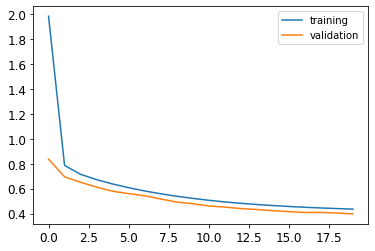

In [10]:
plt.plot(np.arange(0, 20), history.history["mse"], label = 'training')
plt.plot(np.arange(0, 20), history.history["val_mse"], label = 'validation')
plt.legend()

### Functional API

In [11]:
# concat diff layers 
input_ = keras.layers.Input(shape = xtrain.shape[1:])
hidden1 = keras.layers.Dense(30, activation = 'relu')(input_)
hidden2 = keras.layers.Dense(30, activation = 'relu')(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)

model = keras.models.Model(inputs = [input_], outputs = [output])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 30)           930         dense_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_3[0][0]                

In [13]:
model.compile(optimizer=keras.optimizers.SGD(lr=1e-3), loss = 'mse', metrics = ['mse'])
history = model.fit(xtrain, ytrain, epochs = 20, batch_size = 32, validation_data = (xval, yval))

mse_test = model.evaluate(xtest, ytest)
mse_test

[0.4106993816157644, 0.41069952]

## Functional API : Wide and Deep Inputs

In [14]:
input_A = keras.layers.Input(shape=[5], name = 'wide_input')
input_B = keras.layers.Input(shape=[6], name = 'deep_input')
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name = 'output')(concat)
model = keras.models.Model(inputs = [input_A, input_B], outputs = [output])

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
____________________________________________________________________________________________

In [16]:
xtrain_A, xtrain_B = xtrain[:, :5], xtrain[:, 2:]
xval_A, xval_B = xval[:, :5], xval[:, 2:]
xtest_A, xtest_B = xtest[:, :5], xtest[:, 2:]
X_new_A, X_new_B = xtest_A[:3], xtest_B[:3]

history = model.fit((xtrain_A, xtrain_B), ytrain, epochs=20,
                    validation_data=((xval_A, xval_B), yval))
mse_test = model.evaluate((xtest_A, xtest_B), ytest)
y_pred = model.predict((X_new_A, X_new_B))

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

### Multi Output Layers 

In [ ]:
Input_A = keras.layers.Input(shape = xtrain.shape[1])
hidden1 = keras.layers.Dense(30, activation='relu')(Input_A)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)

Output_Aux = keras.layers.Dense(1, name = 'Output_Aux')(hidden1)
Output_Main = keras.layers.Dense(1, name = 'Output_Main')(hidden2)

model = keras.models.Model(inputs = [Input_A], outputs = [Output_Aux, Output_Main])

In [ ]:
model.compile(loss = 'mse', optimizer = 'SGD', metrics = ['mse'])
model.fit(xtrain, (ytrain, ytrain), epochs = 20, batch_size = 32)

## Tensorboard

In [68]:
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2020_09_05-13_11_39'

In [69]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [70]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [73]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

history = model.fit(xtrain, ytrain, epochs=30,
                    validation_data=(xval, yval),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 3s 254us/sample - loss: 1.8423 - val_loss: 5.2165
Epoch 2/30
11610/11610 [==============================] - 1s 104us/sample - loss: 0.6876 - val_loss: 0.7732
Epoch 3/30
11610/11610 [==============================] - 1s 122us/sample - loss: 0.5954 - val_loss: 0.5446
Epoch 4/30
11610/11610 [==============================] - 1s 98us/sample - loss: 0.5553 - val_loss: 0.5425
Epoch 5/30
11610/11610 [==============================] - 1s 93us/sample - loss: 0.5268 - val_loss: 0.5539
Epoch 6/30
11610/11610 [==============================] - 1s 94us/sample - loss: 0.5049 - val_loss: 0.4701
Epoch 7/30
11610/11610 [==============================] - 1s 105us/sample - loss: 0.4852 - val_loss: 0.4562
Epoch 8/30
11610/11610 [==============================] - 1s 89us/sample - loss: 0.4706 - val_loss: 0.4452
Epoch 9/30
11610/11610 [==============================] - 1s 86us/sample - loss: 0.4576 - v

### Hyperparameter Tuning

In [77]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [78]:
def build_model(n_hidden = 1, n_neurons = 30, learning_rate = 1e-3, input_shape = [8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [79]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [81]:
keras_reg.fit(xtrain, ytrain, epochs=10,
              validation_data=(xval, yval),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 3s 286us/sample - loss: 1.8964 - val_loss: 5.9756
Epoch 2/10
11610/11610 [==============================] - 1s 98us/sample - loss: 0.8432 - val_loss: 1.9525
Epoch 3/10
11296/11610 [============================>.] - ETA: 0s - loss: 0.70211610/11610 [==============================] - 1s 87us/sample - loss: 0.6985 - val_loss: 0.9169
Epoch 4/10
11610/11610 [==============================] - 1s 67us/sample - loss: 0.6368 - val_loss: 0.6395
Epoch 5/10
11610/11610 [==============================] - 1s 55us/sample - loss: 0.5967 - val_loss: 0.5522
Epoch 6/10
11610/11610 [==============================] - 1s 59us/sample - loss: 0.5666 - val_loss: 0.5315
Epoch 7/10
11610/11610 [==============================] - 1s 55us/sample - loss: 0.5424 - val_loss: 0.5211
Epoch 8/10
11610/11610 [==============================] - 1s 61us/sample - loss: 0.5222 - val_loss: 0.5048
Epoch 9/10
11610/11610 [==

In [83]:
mse_test = keras_reg.score(xtest, ytest)

5160/5160 [==============================] - 1s 145us/sample - loss: 0.4802


In [88]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = {'n_hidden' : [0, 1, 2, 3],
'learning_rate' : [1e-3, 1e-2]}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_grid, n_iter = 10,
cv = 3, verbose = 2)
rnd_search_cv.fit(xtrain, ytrain, validation_data = (xval, yval),
callbacks = [keras.callbacks.EarlyStopping(patience = 10)])

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] n_hidden=0, learning_rate=0.001 .................................
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Train on 7740 samples, validate on 3870 samples
3870/3870 [==============================] - 0s 70us/sample - loss: 2.7960
[CV] .................. n_hidden=0, learning_rate=0.001, total=   3.6s
[CV] n_hidden=0, learning_rate=0.001 .................................
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
Train on 7740 samples, validate on 3870 samples
3870/3870 [==============================] - 0s 76us/sample - loss: 3.1258
[CV] .................. n_hidden=0, learning_rate=0.001, total=   3.2s
[CV] n_hidden=0, learning_rate=0.001 .................................
Train on 7740 samples, validate on 3870 samples
3870/3870 [==============================] - 0s 52us/sample - loss: 2.6708
[CV] .................. n_hidden=0, learning_rate=0.001

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000000001A1291C8>,
                   param_distributions={'learning_rate': [0.001, 0.01],
                                        'n_hidden': [0, 1, 2, 3]},
                   verbose=2)

In [89]:
rnd_search_cv.best_params_

{'n_hidden': 2, 'learning_rate': 0.01}

In [91]:
rnd_search_cv.best_score_

-0.5073526661474063

In [93]:
rnd_search_cv.score(xtest, ytest)

5160/5160 [==============================] - 1s 143us/sample - loss: 0.4608


-0.4607606052428253